<a href="https://colab.research.google.com/github/adib0073/AiTutorials/blob/main/notebooks/Heart%20Disease%20Classification%20with%20Decision%20Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Heart Disease Classification using Decision Trees

In this notebook, we will try to solve the problem of classifying whether a patient will have heart disease or not using the Heart Disease Dataset using Decision Trees

### About the Data

UCI - Heart Disease Dataset - https://archive.ics.uci.edu/ml/datasets/Heart+Disease

The Heart Disease Dataset is used to solve the problem of classifying whether a patient will have heart disease or not, which is a Binary Classification problem. The data used for this assignment is obtained from Kaggle. This dataset is a processed version of the actual Cleveland database data obtained from UCI Datasets. This problem and the dataset are interesting because the dataset has multiple feature attributes (13 feature attributes) and each of these features are of different types (combination of continuous and categorical values) and the scale of the continuous values are completely different and it will be interesting to see how the Machine Learning algorithms perform on this. Also, the number of records is limited (around 303 records) and there are some outliers observed within the data. So, it will be really interesting to see how our Machine Learning Algorithms can be used to generalize on such a limited dataset with noise. And finally predicting heart disease can have real life use case and application, so that’s why I felt this would be a good problem to investigate.

### Import Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

## Section 1 - Loading the data and exploratory data analysis

### Load the data

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/adib0073/FastAPI_Docker_Deployment/main/uci_heart_disease/Data/heart.csv")
data.head()

,age,sex,chest_pain_type,resting_bp,cholestoral,fasting_blood_sugar,restecg,max_hr,exang,oldpeak,slope,num_major_vessels,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
data.shape

(303, 14)

Data Distribution


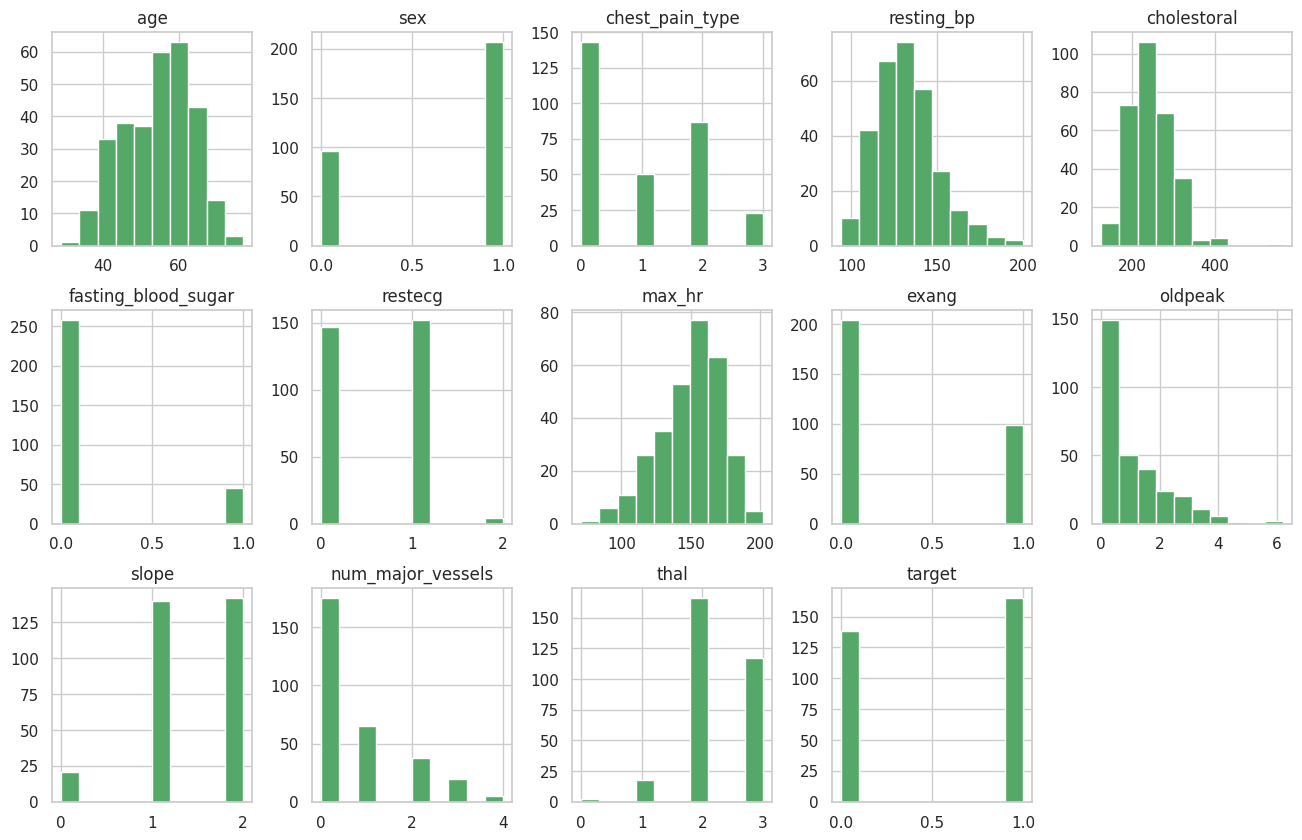

In [5]:
data.hist(layout = (3,5), figsize=(16,10), color = 'g')
print('Data Distribution')

This looks like a fairly balanced dataset, as distribution of majority and minority class is around 55:45


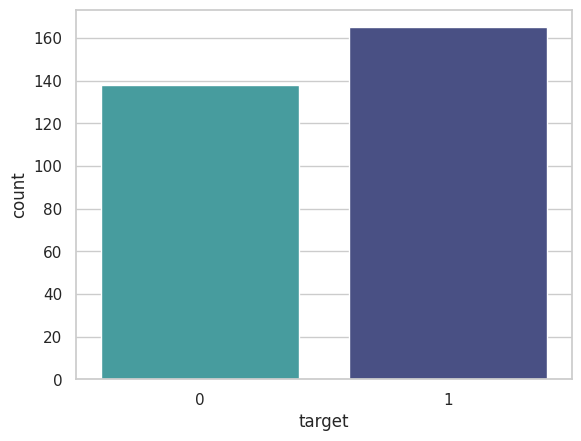

In [6]:
print('This looks like a fairly balanced dataset, as distribution of majority and minority class is around 55:45')
sns.countplot(x="target", data=data, palette="mako_r")
plt.show()

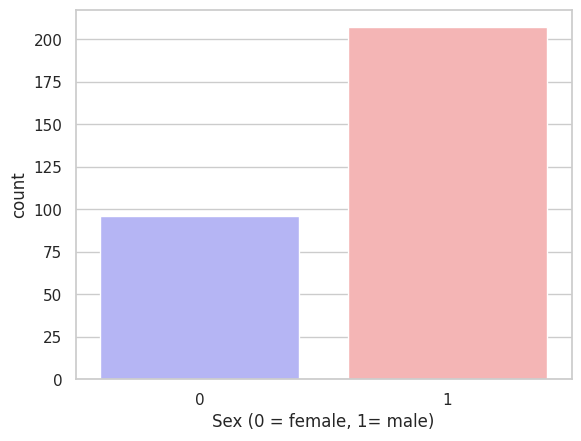

In [7]:
sns.countplot(x='sex', data=data, palette="bwr")
plt.xlabel("Sex (0 = female, 1= male)")
plt.show()

Analysing distribution of target and sex (0-female 1-male)


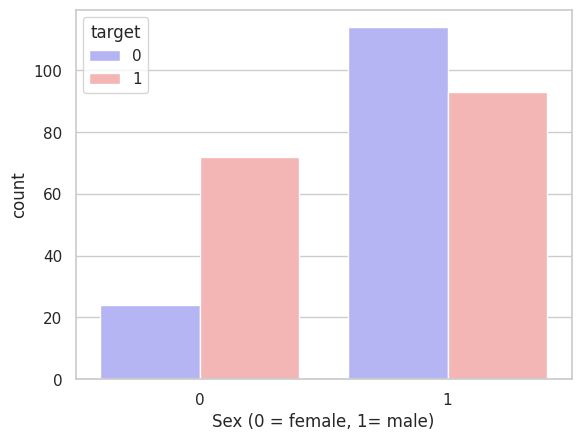

In [8]:
print('Analysing distribution of target and sex (0-female 1-male)')
sns.countplot(x = data['sex'], hue = data['target'], palette='bwr')
plt.xlabel("Sex (0 = female, 1= male)")
plt.show()

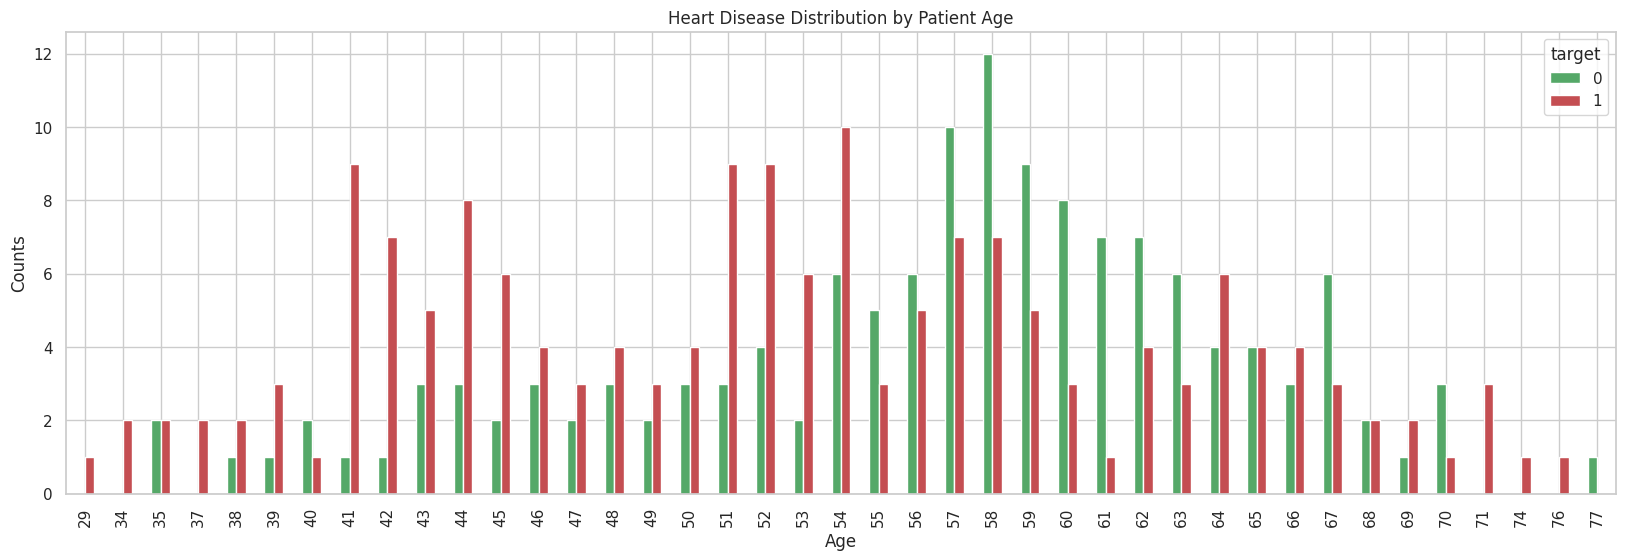

In [9]:
pd.crosstab(data.age,data.target).plot(kind="bar",figsize=(20,6), color = ['g','r'])
plt.title('Heart Disease Distribution by Patient Age')
plt.xlabel('Age')
plt.ylabel('Counts')
plt.show()

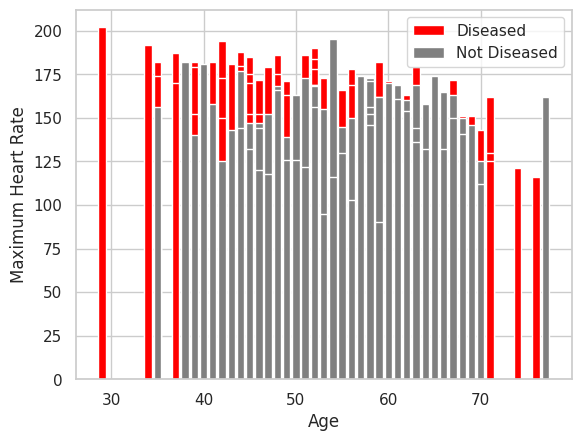

In [10]:
plt.bar(data.age[data.target==1], data.max_hr[(data.target==1)], color="red")
plt.bar(data.age[data.target==0], data.max_hr[(data.target==0)], color="grey")
plt.legend(["Diseased", "Not Diseased"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate")
plt.show()

## Section 2 - Data Pre-processing

In order to have a clean data for final analysis we need to pre-process the data and inspect for duplicate data, correlation, missing values, outliers, one-hot encoding for categorical values etc.

### Null or missing value check

In [11]:
data.isnull().sum()

age                    0
sex                    0
chest_pain_type        0
resting_bp             0
cholestoral            0
fasting_blood_sugar    0
restecg                0
max_hr                 0
exang                  0
oldpeak                0
slope                  0
num_major_vessels      0
thal                   0
target                 0
dtype: int64

We do not see any missing values for this dataset.

### Duplicate inspection

In [12]:
data.duplicated().any()

True

Looks like the dataset has some duplicates. Let's remove the duplicates

In [13]:
data.drop_duplicates(subset=None, inplace=True)
data.duplicated().any()

False

In [14]:
data.shape

(302, 14)

So, we can see that there was one duplicate row

### One Hot Encoding

Since we have many categorical values withn the data, we would need to do one-hot encoding to convert the categorical values to discrete real values for a better noise-free analysis

In [15]:
def encode_features(df, features):
    '''
    Method for one-hot encoding all selected categorical fields
    '''
    for f in features:
        if(f in df.columns):
            encoded = pd.get_dummies(df[f])
            encoded = encoded.add_prefix(f + '_')
            df = pd.concat([df, encoded], axis=1)
        else:
            print('Feature not found')
            return df

    df.drop(columns=features, inplace = True)

    return df

In [16]:
features_to_encode = ['thal', 'slope', 'chest_pain_type', 'restecg']
encoded = encode_features(data, features_to_encode)
data = encoded.copy()
print(data.shape)

(302, 24)


In [17]:
data.columns

Index(['age', 'sex', 'resting_bp', 'cholestoral', 'fasting_blood_sugar',
       'max_hr', 'exang', 'oldpeak', 'num_major_vessels', 'target', 'thal_0',
       'thal_1', 'thal_2', 'thal_3', 'slope_0', 'slope_1', 'slope_2',
       'chest_pain_type_0', 'chest_pain_type_1', 'chest_pain_type_2',
       'chest_pain_type_3', 'restecg_0', 'restecg_1', 'restecg_2'],
      dtype='object')

After one hot encoding we see that 14 new columns are added and the 4 categorical columns are dropped

### Outlier Inspection

In [18]:
data.describe()

,age,sex,resting_bp,cholestoral,fasting_blood_sugar,max_hr,exang,oldpeak,num_major_vessels,target,...,slope_0,slope_1,slope_2,chest_pain_type_0,chest_pain_type_1,chest_pain_type_2,chest_pain_type_3,restecg_0,restecg_1,restecg_2
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,...,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.00000,302.000000
mean,54.42053,0.682119,131.602649,246.500000,0.149007,149.569536,0.327815,1.043046,0.718543,0.543046,...,0.069536,0.463576,0.466887,0.473510,0.165563,0.284768,0.076159,0.486755,0.50000,0.013245
std,9.04797,0.466426,17.563394,51.753489,0.356686,22.903527,0.470196,1.161452,1.006748,0.498970,...,0.254786,0.499499,0.499730,0.500126,0.372305,0.452053,0.265693,0.500654,0.50083,0.114512
min,29.00000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,48.00000,0.000000,120.000000,211.000000,0.000000,133.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,55.50000,1.000000,130.000000,240.500000,0.000000,152.500000,0.000000,0.800000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.50000,0.000000
75%,61.00000,1.000000,140.000000,274.750000,0.000000,166.000000,1.000000,1.600000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.00000,0.000000
max,77.00000,1.000000,200.000000,564.000000,1.000000,202.000000,1.000000,6.200000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


From manual inspection, we do see that for cholestoral and oldpeak we may have some outliers

### Data Correlation

age                   -0.221476
sex                   -0.283609
resting_bp            -0.146269
cholestoral           -0.081437
fasting_blood_sugar   -0.026826
max_hr                 0.419955
exang                 -0.435601
oldpeak               -0.429146
num_major_vessels     -0.408992
target                 1.000000
thal_0                -0.007056
thal_1                -0.105986
thal_2                 0.526030
thal_3                -0.484887
slope_0               -0.062822
slope_1               -0.360258
slope_2                0.392121
chest_pain_type_0     -0.514626
chest_pain_type_1      0.247649
chest_pain_type_2      0.313696
chest_pain_type_3      0.087959
restecg_0             -0.157299
restecg_1              0.172827
restecg_2             -0.068156
Name: target, dtype: float64


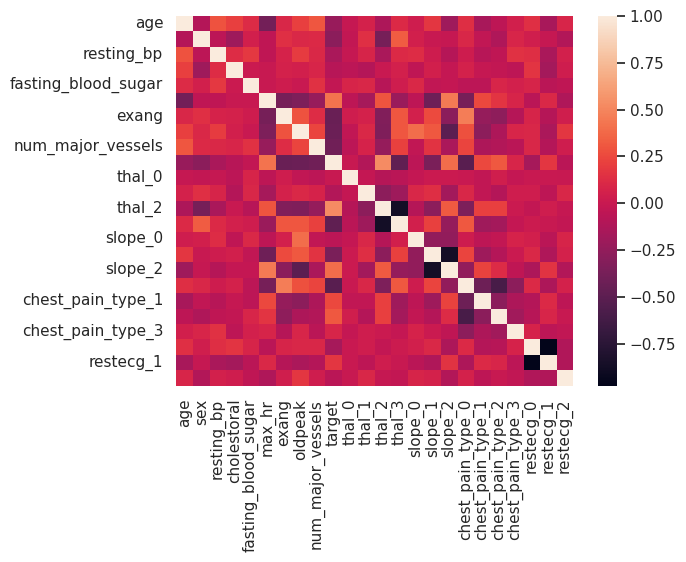

In [19]:
print(data.corr()['target'])
sns.heatmap(data.corr())
plt.show()

It is observed that the features does not have a strong correlation (>0.6) with the target. Otherwise correlated or inversely correlated values had to be removed to remove any additional training bias

## Section -3 : Feature Engineering

In this step we will remove outliers on non categorical fields using Nelson's 1st rule and normalize the data for a better model generalization and efficiency.

In [20]:
feature_engg_data = data.copy()
outlier_data = data.copy()
target_index = data.columns.get_loc("target") # Use this for separating the target labels from data
factor = 3
# Include this only for columns with suspected outliers
# Using a factor of 3, following Nelson's rule 1 to remove outliers - https://en.wikipedia.org/wiki/Nelson_rules
# Only for non-categorical fields
columns_to_include = ['age', 'resting_bp', 'cholestoral', 'max_hr', 'oldpeak', 'num_major_vessels']
for column in columns_to_include:
    upper_lim = feature_engg_data[column].mean () + feature_engg_data[column].std () * factor
    lower_lim = feature_engg_data[column].mean () - feature_engg_data[column].std () * factor
    feature_engg_data = feature_engg_data[(feature_engg_data[column] < upper_lim) & (feature_engg_data[column] > lower_lim)]

outlier_data = pd.concat([outlier_data, feature_engg_data]).drop_duplicates(keep=False)

In [21]:
print(feature_engg_data.shape)
print(outlier_data.shape)

(289, 24)
(13, 24)


In the following section in-order to build the model, we will need to normalize the data and split the data into train, validation and test dataset. The outlier data that we have, we will keep it separate, just in case to see how does our model performs on the outlier dataset.

#### Data Normalization

In [22]:
from sklearn import preprocessing

def normalize_data(df):
    val = df.values
    min_max_normalizer = preprocessing.MinMaxScaler()
    norm_val = min_max_normalizer.fit_transform(val)
    df2 = pd.DataFrame(norm_val)

    return df2

norm_feature_engg_data = normalize_data(feature_engg_data)
norm_outlier_data = normalize_data(outlier_data)

In [23]:
norm_feature_engg_data = normalize_data(feature_engg_data)
norm_outlier_data = normalize_data(outlier_data)

#### Data Splits

Splitting Feature Engineered Data into train-valid-test dataset in 70:20:10 Ratio, the choice of selecting this splitting ratio is to ensure we have sufficient training data, sufficient validation data for mainly hyper parameter tuning and sufficient testing data to ensure model generalization.

In [24]:
from sklearn.model_selection import train_test_split

input_data = norm_feature_engg_data.drop([target_index],axis='columns')
targets =norm_feature_engg_data.filter([target_index],axis='columns')

x, x_test, y, y_test = train_test_split(input_data,targets,test_size=0.1,train_size=0.9, random_state=5)
x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size = 0.22,train_size =0.78, random_state=5)

## Section 4 -  Building the Model

#### Model Evaluation Metrics

For model evaluation we will use AUC-ROC Scores, Accuracy and Confusion matrix to see how well the model is generalized and efficient on mainly validation and test sets. But these metric will be initially used on the test set to see how well the model fits on the training data and is there any significant bias on the training set.

In [25]:
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix
import math
import seaborn as sns

def evaluatation_metrics(y_true, y_pred,model):

    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    print("Accuracy of",model,": {:.2f}".format(accuracy))
    print("ROC AUC Score of", model,": {:.2f}".format(roc_auc))
    print("Confusion Matrix of", model,": \n")

    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    title = 'AUC-ROC Score: {:.2f}'.format(roc_auc)
    plt.title(title)
    plt.show()

In [26]:
import time

def ml_model(classifier, classifier_name, **kwargs):
    '''
    Generic method to train the selected classification algorithm on train, validation and test dataset.
    '''
    # Fit model
    if kwargs['x_train'] is not None:
        model = classifier.fit(kwargs['x_train'], kwargs['y_train'])
        y_pred_train= model.predict(kwargs['x_train'])
        print('*****************************************************')
        print('Training Set Performance:')
        print('*****************************************************')
        evaluatation_metrics(kwargs['y_train'], y_pred_train, classifier_name)

    if kwargs['x_valid'] is not None:
        y_pred_valid = model.predict(kwargs['x_valid'])
        print('*****************************************************')
        print('Validation Set Performance:')
        print('*****************************************************')
        evaluatation_metrics(kwargs['y_valid'], y_pred_valid, classifier_name)

    if kwargs['x_test'] is not None:
        start = time.time()
        y_pred_test= classifier.predict(kwargs['x_test'])
        end = time.time()
        print('*****************************************************')
        print('Test Set Performance:')
        print('*****************************************************')
        print('Model Time Complexity on Test Data: {:.3f} milli seconds'.format((end - start) * 1000))
        evaluatation_metrics(kwargs['y_test'], y_pred_test, classifier_name)

In [27]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curves(train_sizes, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std, model_name):
    '''
    Method to generate learning curves for using training and cross validation scores
    '''
    plt.title(model_name)

    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

def plot_model_scalability_curves(train_sizes, training_time_mean, training_time_std, model_name):
    '''
    Method to generate scalability curve to see the model complexity
    '''
    plt.plot(train_sizes, training_time_mean, 'o-', color = 'purple')
    plt.fill_between(train_sizes, training_time_mean - training_time_std,
                         training_time_mean + training_time_std, alpha=0.1, color = 'purple')
    plt.xlabel("Training examples")
    plt.ylabel("Training time")
    plt.title("Scalability of "+ model_name)
    plt.show()

def plot_model_performance_curves(training_time_mean, test_scores_mean, test_scores_std, model_name):
    '''
    Method to generate performance curves to see if increase model complexity would improve score or not
    '''
    plt.plot(training_time_mean, test_scores_mean, 'o-')
    plt.fill_between(training_time_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    plt.xlabel("Training Time")
    plt.ylabel("Score")
    plt.title("Performance of "+ model_name)
    plt.show()


def generate_learning_curves(model, model_name, X, y, xlim = None, ylim=None,
                         epochs =None, figsize = (20,5)):
    '''
    Generic method to generate Learning Curves, Scalability curves and Performance curves
    Referred - https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
    '''
    cross_valid = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

    train_sizes=np.linspace(.1, 1.0, 5)
    train_sizes, train_scores, test_scores, training_time, _ = learning_curve(model, X, y, cv=cross_valid,
                                                                           n_jobs=epochs, train_sizes=train_sizes,
                                                                           return_times=True)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)

    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    training_time_mean = np.mean(training_time, axis=1)
    training_time_std = np.std(training_time, axis=1)

    # Plot learning curve
    plot_learning_curves(train_sizes, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std, model_name)

    # Plot scalability curve
    plot_model_scalability_curves(train_sizes, training_time_mean, training_time_std, model_name)

    # Plot model performance score
    plot_model_performance_curves(training_time_mean, test_scores_mean, test_scores_std, model_name)

### Classification Algorithms

#### Baseline -  Decision Tree

*****************************************************
Training Set Performance:
*****************************************************
Accuracy of Decision Tree : 1.00
ROC AUC Score of Decision Tree : 1.00
Confusion Matrix of Decision Tree : 



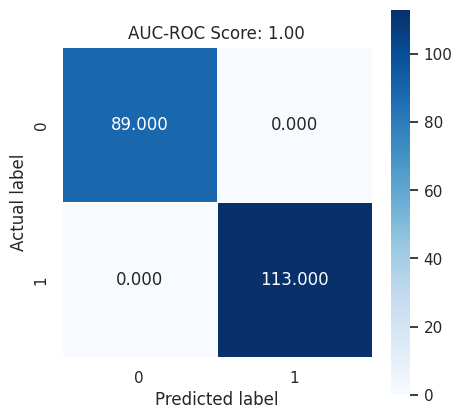

*****************************************************
Validation Set Performance:
*****************************************************
Accuracy of Decision Tree : 0.71
ROC AUC Score of Decision Tree : 0.71
Confusion Matrix of Decision Tree : 



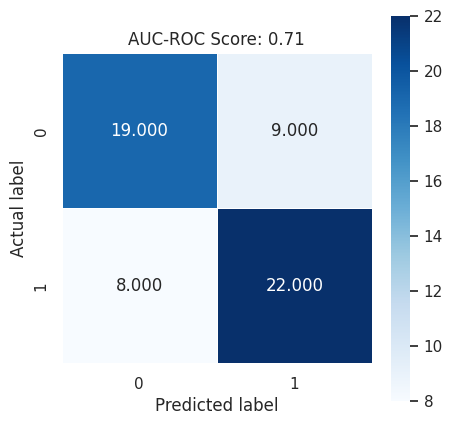

In [28]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

DTC = DecisionTreeClassifier(criterion='entropy', random_state=3) # Baseline model without any form of pruning
ml_model(DTC, 'Decision Tree', x_train = x_train, y_train = y_train, x_valid = x_valid, y_valid = y_valid, x_test = None)

We see how poorly the baseline decision tree model performs on the validation set. This is due to very high over-fitting on training data. The overfitting is happening for both Gini Index and Entropy.
Gini index operates on the categorical target variables in terms of “true” and “false” and performs only binary split, in opposite to that Information Gain computes the difference between entropy before and after the split and indicates the impurity in classes of elements.

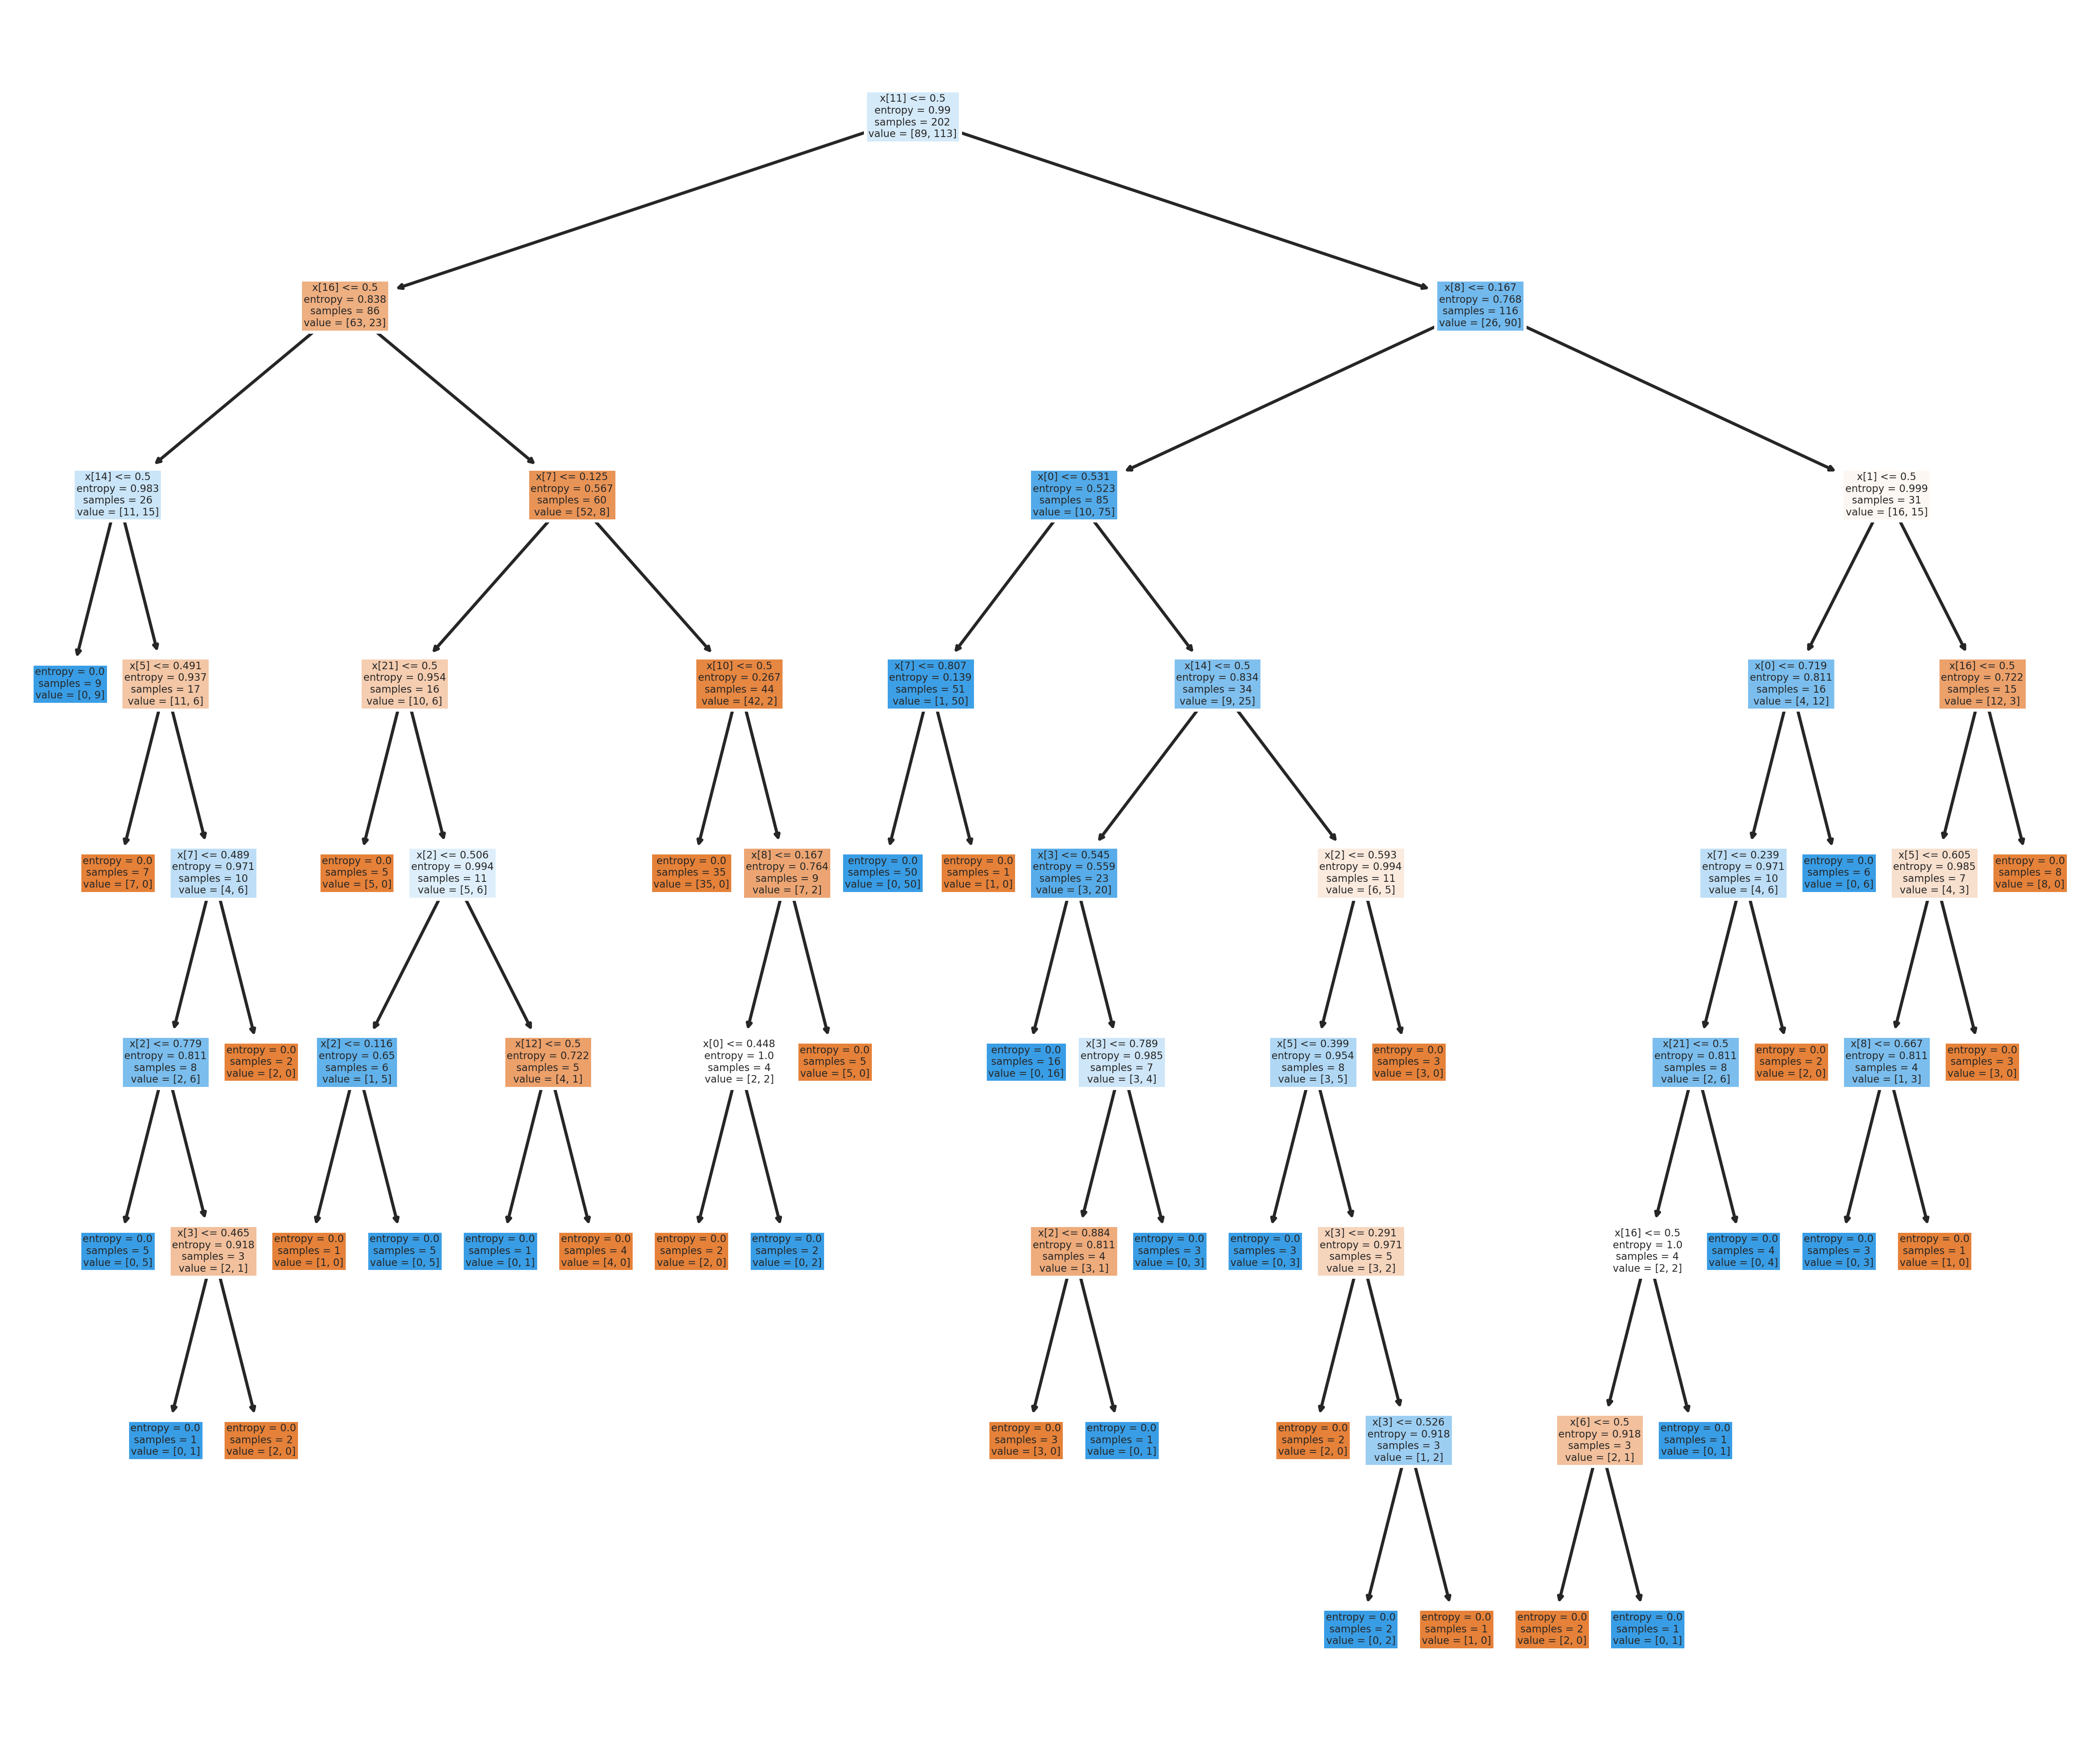

In [29]:
# Visualizing Decision Trees
fig, axes = plt.subplots(figsize = (12,10), dpi=500)
plot_tree(DTC,filled = True)
plt.show()

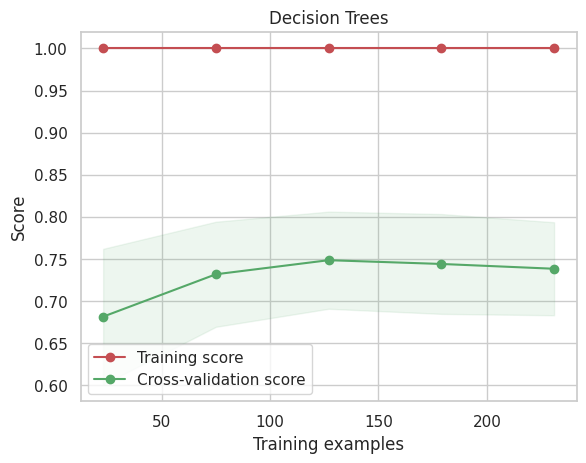

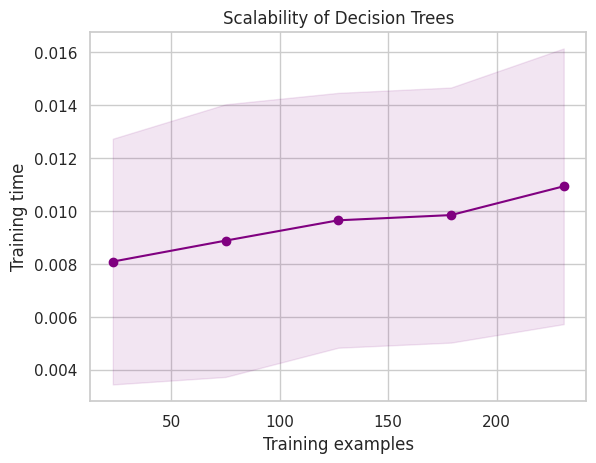

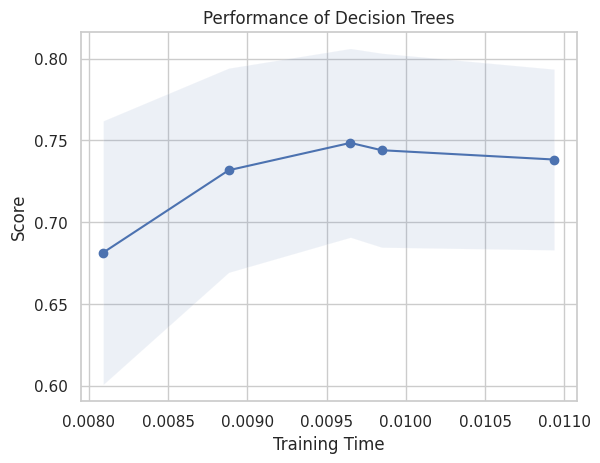

In [30]:
# Generation model curves on training and cross validation data
generate_learning_curves(
    model = DTC,
    model_name = "Decision Trees",
    X = input_data,
    y = targets,
    ylim=(0.7, 1.01),
    epochs=5)

These curves are showing presence of high overfiting on basseline model, but the model time may be almost constan, hence almost constant time complexity, but the performance curve shows no significant improvment with more training time and training samples.

#### Hyper-parameter tuning

In this step, we will do post pruning to find the best parameter values for maximum depth of the tree and minimum leaf samples for the decision tree, so as to prevent it from over-fitting and generalizing the model. First we will use Grid Search to short list initial hyper parameter values.

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
# We will apply grid search to find the best possible set of hyper parameters
def DTGridSearch(X,y,param_lim):
    '''
    Decision Tree Grid Search to find the initial best guess of hyper-parameters
    '''
    param_grid = {
                    'min_samples_leaf':np.linspace(param_lim[0],param_lim[1],20).astype('int'),
                    'max_depth':np.arange(1,param_lim[2]),
                    'criterion' : ['entropy' , 'gini']
    }

    best_DT = GridSearchCV(estimator = DecisionTreeClassifier(random_state=3), param_grid=param_grid, cv=10)
    best_DT.fit(X, y)

    print("Best Decision Tree Hyper-Parameters are:")
    print(best_DT.best_params_)

    return best_DT.best_params_['min_samples_leaf'], best_DT.best_params_['max_depth'], best_DT.best_params_['criterion']

In [33]:
min_samples_leaf_lim = int(0.005 * len(x_train)) # 0.5% of length of training size
max_samples_leaf_lim = int(0.1 * len(x_train)) # 10% of length of training size
max_depth = 10

best_min_sample_leaf, best_max_depth, best_criterion = DTGridSearch( x_train,
                                                                     y_train,
                                                                     (min_samples_leaf_lim, max_samples_leaf_lim, max_depth)
                                                                   )

Best Decision Tree Hyper-Parameters are:
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 12}


Now, although grid search is done on training set, in-order to check the generalization, we would iterate with various depth of the tree on both training and validation dataset, and pickup the best depth (one with lowest error rate) and consider that as the final version of the best parameters.

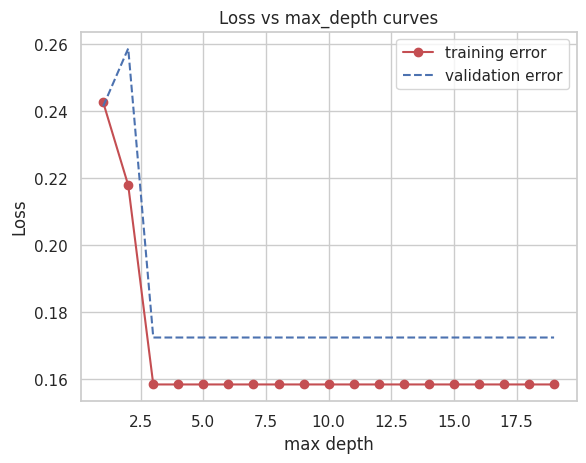

In [34]:
train=[]
valid=[]
for i in range(1,20):
    dec = DecisionTreeClassifier(criterion = 'gini', min_samples_leaf = 12, random_state=3, max_depth=i)
    dec.fit(x_train, y_train)
    train.append(1- accuracy_score(dec.predict(x_train), y_train))
    valid.append(1- accuracy_score(dec.predict(x_valid), y_valid))

plt.title('Loss vs max_depth curves')
depth=[i for i in range(1,20)]
plt.plot(depth,train,'o-', color = 'r', label = 'training error')
plt.plot(depth,valid, '--', color = 'b', label = 'validation error')
plt.xlabel('max depth')
plt.ylabel('Loss')
plt.legend()

The loss curve also shows some over-fitting, but the lowest loss is obtained for a max_depth = 3. Now, let's apply these hyper-parameter values and let's see the model performance and generalization.

*****************************************************
Training Set Performance:
*****************************************************
Accuracy of Decision Tree : 0.84
ROC AUC Score of Decision Tree : 0.84
Confusion Matrix of Decision Tree : 



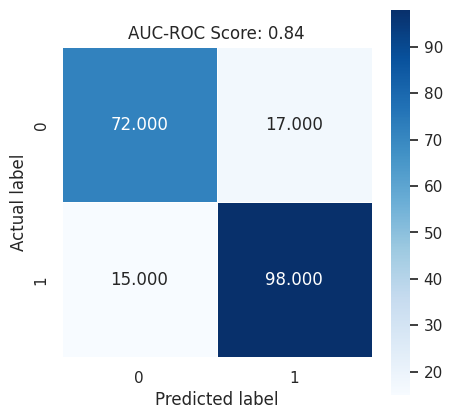

*****************************************************
Validation Set Performance:
*****************************************************
Accuracy of Decision Tree : 0.83
ROC AUC Score of Decision Tree : 0.83
Confusion Matrix of Decision Tree : 



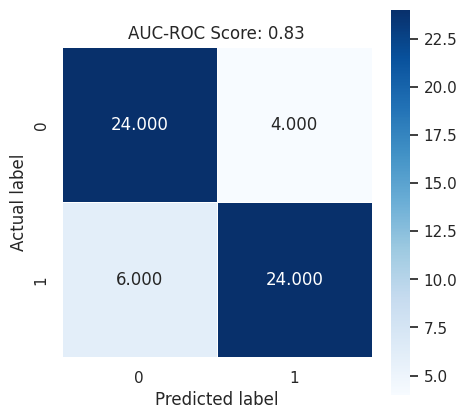

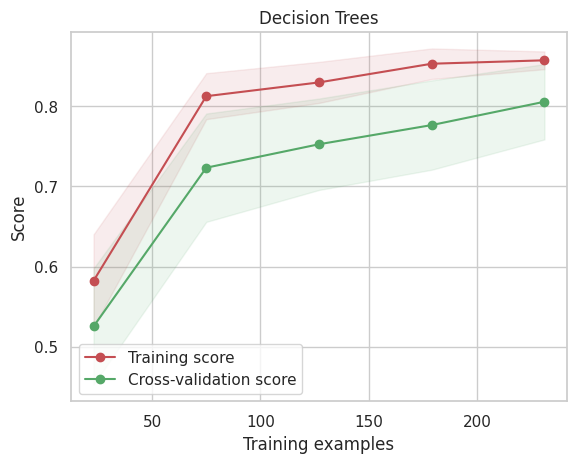

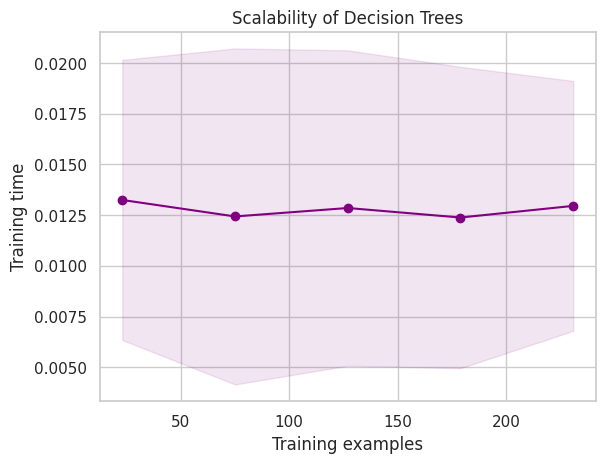

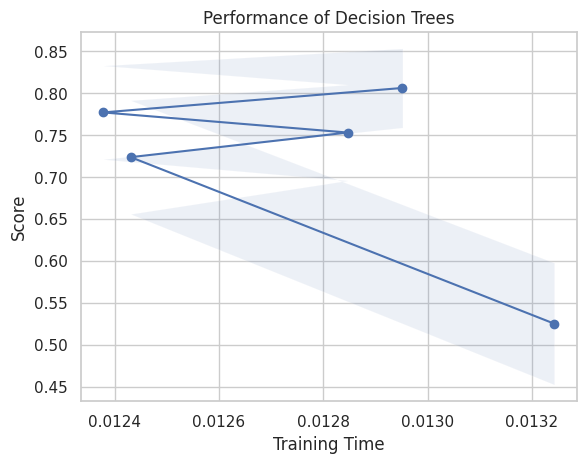

In [35]:
tuned_DTC = DecisionTreeClassifier(criterion='gini', max_depth = 3, min_samples_leaf = 12, random_state=3)
ml_model(tuned_DTC, 'Decision Tree', x_train = x_train, y_train = y_train, x_valid = x_valid, y_valid = y_valid, x_test = None)

generate_learning_curves(
    model = tuned_DTC,
    model_name = "Decision Trees",
    X = input_data,
    y = targets,
    ylim=(0.7, 1.01),
    epochs=5)

The tuned decision tree does show significant improvement in model performance, with an inrease in AUC-ROC score by 12% and is very well generalized as no significant over-fitting, but we can say that the model has some bias and hence it might be under-fitting. But the hyper-parameter tuning process was successful as we see performance improvment from baseline model.

## Section 5 : Model Performance on Test Data

For the tuned Decision Tree model :

*****************************************************
Test Set Performance:
*****************************************************
Model Time Complexity on Test Data: 8.487 milli seconds
Accuracy of tuned Decision Tree : 0.79
ROC AUC Score of tuned Decision Tree : 0.81
Confusion Matrix of tuned Decision Tree : 



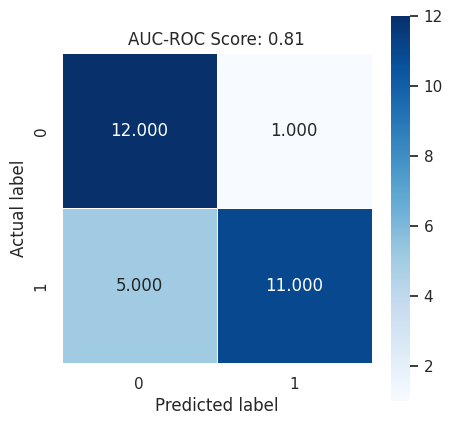

In [36]:
print('For the tuned Decision Tree model :\n')
ml_model(tuned_DTC, 'tuned Decision Tree', x_train = None, x_valid = None, x_test = x_test, y_test = y_test.values.ravel() )

### Acknowledgements

Kaggle Data Source Link: https://www.kaggle.com/ronitf/heart-disease-uci


Creators of the original dataset:

1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

Donor of origianl dataset:
- David W. Aha (aha '@' ics.uci.edu) (714) 856-8779